In [4]:
import numpy as np
print( 'numpy version: ', np.__version__ )

import matplotlib
print( 'matplotlib version: ', matplotlib.__version__ )

#from lsst.daf.persistence import Butler # gen2 butler
import lsst.daf.butler as dafButler     # gen3 butler
# What version of the LSST Science Pipelnes are we using?
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

import pandas as pd
pd.set_option('display.max_rows', 1000)

import lsst
import lsst.sphgeom

# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt
import warnings                      # imports the warnings library

from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

from IPython.display import Markdown as md

# from rubin_jupyter_utils.lab.notebook import get_catalog, retrieve_query    
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query    

import lsst.afw.display as afwDisplay
import lsst.geom
from lsst.geom import SpherePoint, Angle
afwDisplay.setDefaultBackend('matplotlib') 

repo = 's3://butler-us-central1-dp01'  
#collection='2.2i/runs/DP0.1'
#collection='1.2i/runs/DP0.1'

# Get an instance of the TAP service
service = lsst.rsp.get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

dataset='DC2'
#genvers='gen2'
genvers='gen3'
# Temporary "fix" so one does not need to restart kernel 
#  when switching from DC2 to HSC...
# See also:  https://lsstc.slack.com/archives/C3UCAEW3D/p1584386779038000
#import lsst.afw.image as afwImage
#print(afwImage.Filter.getNames())
#afwImage.Filter.reset()
#import lsst.obs.base as obsBase
#obsBase.FilterDefinitionCollection.reset()
#print(afwImage.Filter.getNames())

# Access DC2 gen3 repository
#repo='/repo/dc2'
#collection='2.2i/runs/DP0.1'
#repo='s3://butler-us-central1-dp01'
collection=['2.2i/runs/DP0.1/calexp/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u', 
                    '2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy',
                    'skymaps']

# Open the butler for this gen3 repo...
butler = dafButler.Butler(repo,collections=collection)

import matplotlib.pyplot as plt

numpy version:  1.23.5
matplotlib version:  3.6.3
Recommended (Weekly 2023_21)
lsst_distrib          gdf42428520+d521942ec3 	current w_2023_21 setup


/tmp/ipykernel_8746/895788265.py:41: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = lsst.rsp.get_tap_service()


In [7]:
#This is the subscript for the array
ii = 0

filter_id = 'r'
data = pd.read_csv('input.txt', delim_whitespace=True)

ra1 = data['RA']
dec1 = data['DEC']
#mag1 =  data['mag_r_2']

#print(ra1)

#print(ra.iloc[1])

ra = ra1.iloc[ii]
dec = dec1.iloc[ii]
#mag_r = mag1.iloc[ii]

In [8]:
#my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
print(my_spherePoint)

#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
tract1 = str(my_tract)
patch1_ok = str(my_patch_id)
tract1_ok = tract1[13:17]
tract = int(tract1_ok)
patch = int(patch1_ok)

#dataId = """{'band': """+"""'"""+filter_id+"""','tract': """+tract1_ok+""", 'patch':"""+tract2+"""}"""

dataId = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(patch1_ok)}

print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ',my_patch_id)
print(dataId)

(60.2322769700, -36.7029511700)
my_tract =  TractInfo(id=3830)
my_patch =  PatchInfo(index=Index2D(x=3, y=2))
my_patch_id =  17
{'band': 'r', 'tract': 3830, 'patch': 17}


In [9]:
coadd_type = 'deepCoadd'

if genvers == 'gen2':
    butler.getKeys(coadd_type)
elif genvers == 'gen3':
    print(butler.registry.getDatasetType(coadd_type).dimensions.required.names)
print(dataId)

dict_keys(['band', 'skymap', 'tract', 'patch'])
{'band': 'r', 'tract': 3830, 'patch': 17}


In [10]:
print(filter_id)
# Retrieve the image using butler
if genvers == 'gen2':
    coadd_id = {'tract': tract, 'patch': patch, 'filter': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)
elif genvers == 'gen3':
    coadd_id = {'tract': tract, 'patch': patch, 'band': filter_id}
    image = butler.get(coadd_type, dataId=coadd_id)

print(tract)
print(patch)
print(filter_id)
print(dataId)

r
3830
17
r
{'band': 'r', 'tract': 3830, 'patch': 17}


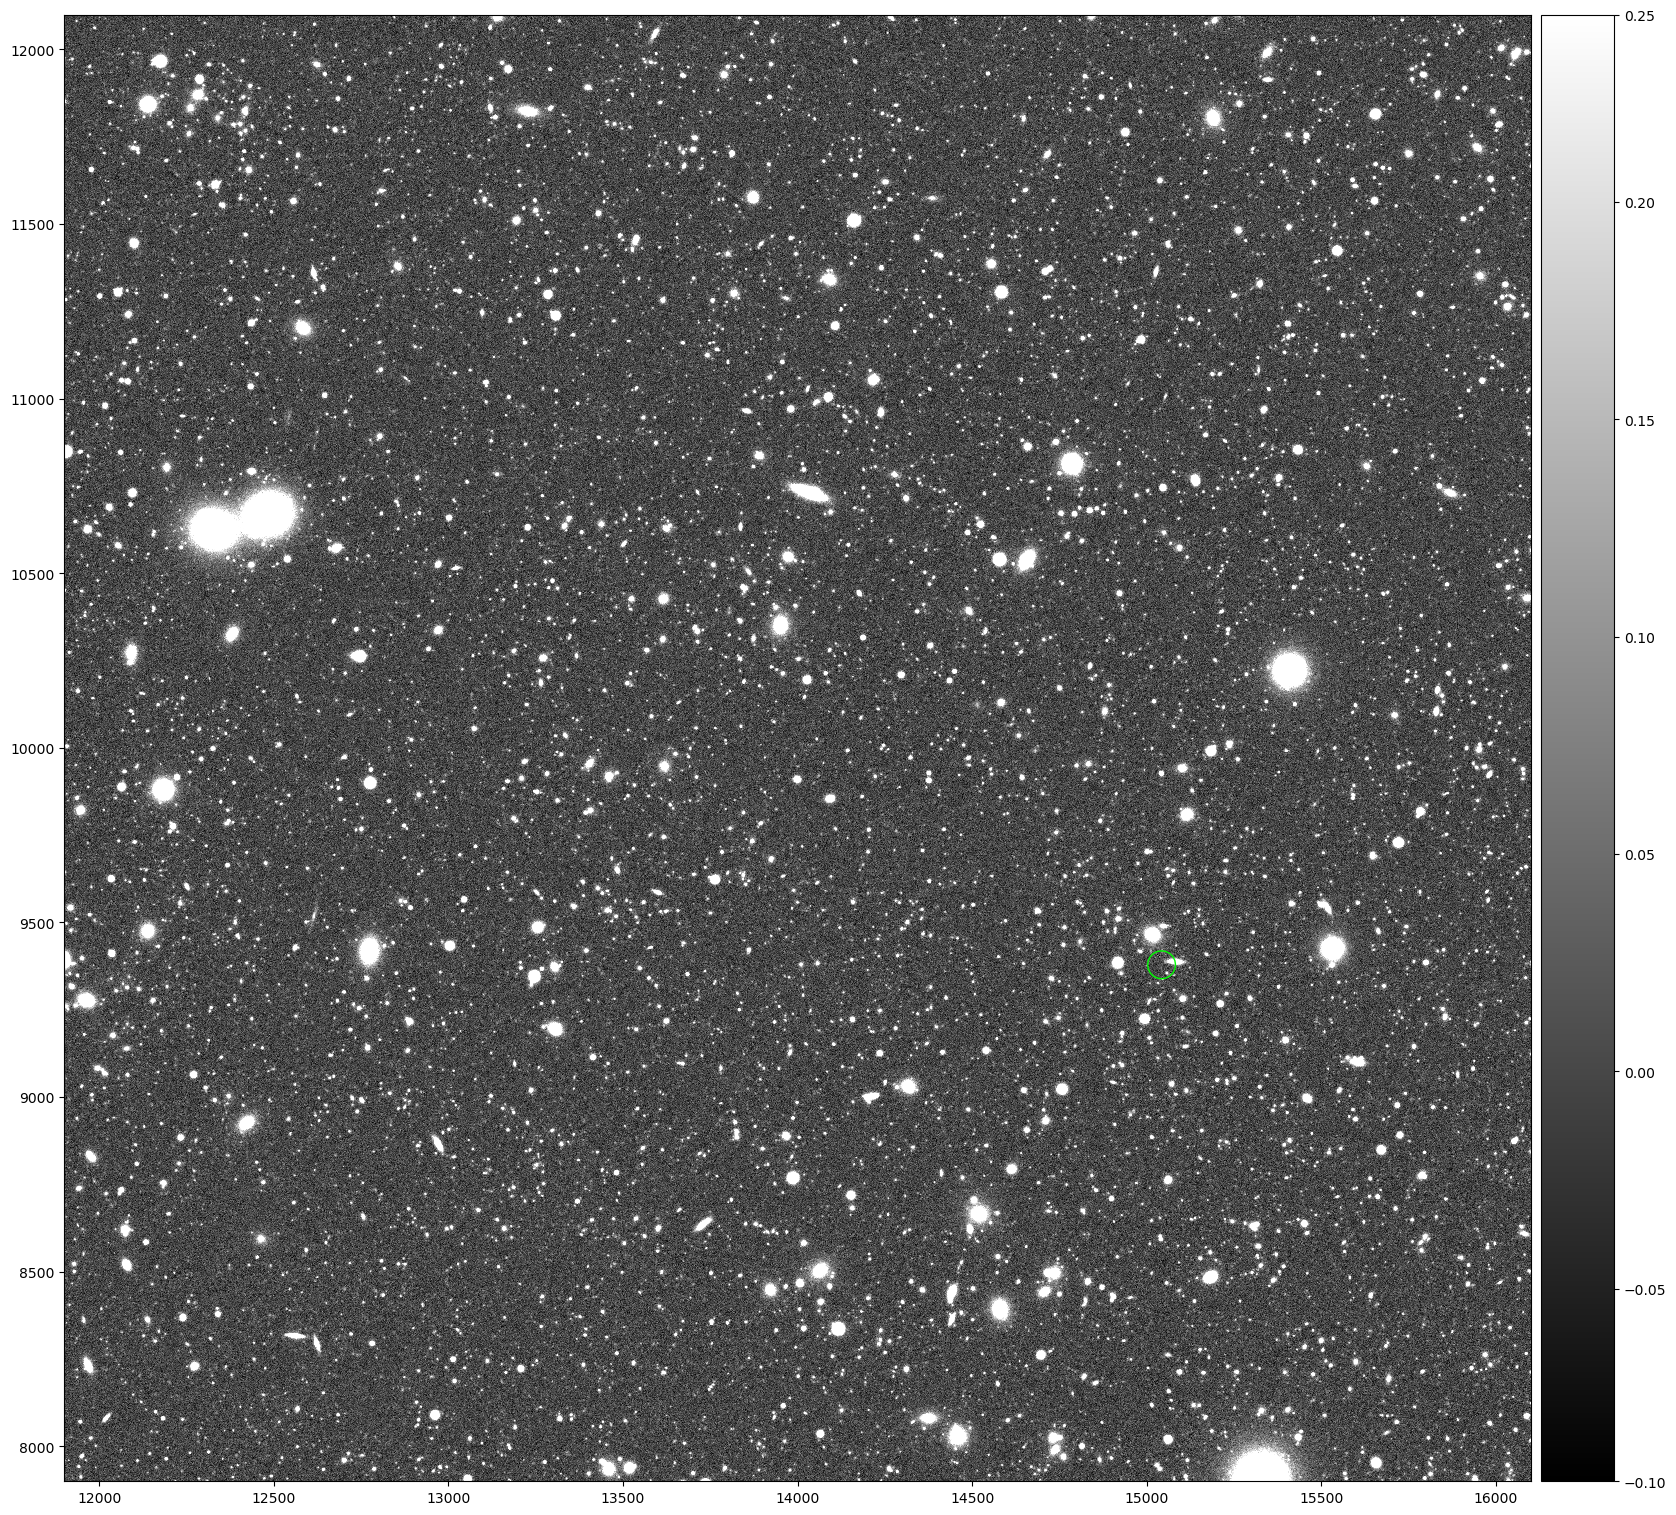

In [11]:
# Let's take a look at the full image first
radec = SpherePoint(ra, dec, lsst.geom.degrees)
xy = image.getWcs().skyToPixel(radec)

fig = plt.figure(figsize=(20,20))
display = afwDisplay.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(image.getMaskedImage().getImage())
display.dot('o', xy.getX(), xy.getY(), ctype='green', size =40)